# Predicting direction of SP500 daily returns using Hidden Markov Models

### Shahnawaz Khalid

## Introducion to Hidden Markov Models

Hidden Markov models are used to model a discrete random system where the output depends on some 'hidden' state that is not visible to the observer. The output at each time step is random and it's probablity distribution depends on the current state of the underlying Markov Chain. 

We can illustrate this with an example. Suppose we play a game with two identical six sided dice. One dice is fair  and has 6 outcomes with equal probability. The second one is loaded and rolls a 6 with probability 0.5 and all the rest with 0.1. During the game the dice are randomly switched and it is impossible for us to know exactly which dice is being currently used. We can only observe the distribution of the numbers being rolled and as such we can only guess whether we are using a fair or loaded dice. For exmaple, if there is a sequence of numbers where the majority is 6, then we can reasonably infer that we were using the loaded die.

Hidden Markov models are used to model such a system. Given a sequence of dice rolls generated by a Markov process that can move between the fair and the unfair state, we are interested in trying to see how accurately can the HMM *decode* the correct underlying sequence i.e. recover the hidden sequence.

### Formal defintion

Formally, an HMM has the following components:

* $Q = \{q_i\}^N ,$ a set of $N$ hidden states
* $A = \{ a_{i,j} \}^{N,N},$ a transition matrix for the hidden states

* $O = (o_1, o_2, \ldots, o_T),$ a sequence of $T$ observations

* $B = b_i(o_t) =: \mathbb{P} (O = o_t | Q = q_i)$ a sequence of observation likelihoods or emission      probabilities, each expressing the probability of observing $o_t$ from a state $q_i$.
    
* $\pi = (\pi_i, \ldots, \pi_N)$ an initial probability distribution of the states $Q$.

There are three fundamental problems that the HMM can solve:

1. **Likelihood**: Given an HMM $(A,B)$ and an observation sequence $O$, determine the likelihood $\mathbb{P}(O|A,B)$
2. **Decoding**: Given an observed sequence $O$, find the best hidden sequence $Q$
3. **Learning**: Given an observed sequence $O$ and the set of states $Q$, learn the paremeters $A,B$



## Evaluating HMM performance using a simple 2-state Markov Chain

We would first like to observe how well HMM's perform on simple test cases. We simulate a 2-state Marko chain and then use the HMM to see how accurately it can decode the hidden sequence. We use the *hmmlearn* library (https://hmmlearn.readthedocs.io/en/latest/) to develop the HMM model.

We take the same dice rolling game as described above to be our Markov chain. There are two states: fair and loaded and they switch between the two under a some transition matrix. We evaluate the accuracy of the HMM by varying the trasition matrix probabilities. 



In [2]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from hmmlearn import hmm, base
from scipy import stats
import seaborn as sns
#np.random.seed(42)
from matplotlib.pyplot import figure

import warnings
warnings.filterwarnings('ignore')

In [5]:
# Different outcomes of the die
xk = np.arange(1,7)

# Array for the prob. mass function
p_f = np.array([1/6, 1/6, 1/6, 1/6, 1/6, 1/6])
p_uf = np.array([0.1, 0.1, 0.1, 0.1, 0.1, 0.5])

# Creates random variables for each roll with the corresponding distribution
fair = stats.rv_discrete(name='fair', values=(xk, p_f))
unfair = stats.rv_discrete(name='unfair', values=(xk, p_uf))


# Generates a sequence of N rolls along with corresponding states
def generate_rolls(N, p_f, p_uf):
    
    curr_state = 0
    switch = 0
    rolls = [fair.rvs()]
    state = [0]
    
    for _ in range(N-1):
        
        A = np.random.rand()
        if curr_state == 0:
            if A < p_f:
                curr_state=0
                state.append(curr_state)
                rolls.append(fair.rvs())
                continue
            else:
                curr_state = 1
                switch += 1
                state.append(curr_state)
                rolls.append(unfair.rvs())
                continue
        if curr_state == 1:
            if A < p_uf:
                curr_state = 1
                state.append(curr_state)
                rolls.append(unfair.rvs())
                continue
            else:
                curr_state=0
                switch += 1
                state.append(curr_state)
                rolls.append(fair.rvs())
                continue
                
    return np.array(rolls), np.array(state)
                
  

The transition probabilities of remaining within each state were taken to be from 0.1 to 0.9 with increments of 0.1. For each entry $a_{i,j}$ of the transition matrix, we generated a seqeuence of 100 rolls and used the HMM to decode the hidden sequence. This was repeated 100 times and the mean accuracy for each $a_{i,j}$ is given below in the heat map.

In [10]:
Probs = np.arange(0.1, 1, 0.1) 
ACC_mean = np.zeros((9,9))

for i in range(0,9):
    for j in range(0,9):
        p_fair = (i+1)*0.1
        p_unfair = (j+1)*0.1
        
        model = hmm.MultinomialHMM(n_components=2, init_params='e', algorithm='viterbi', n_iter = 500)
        model.startprob_ = np.array([1, 0])
        model.transmat_ = np.array([[p_fair, 1-p_fair],[1-p_unfair, p_unfair]])
        model.emissionprob_ = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6],[0.1,0.1,0.1,0.1,0.1, 0.5]])
        
        accuracy = []

        for _ in range(100):
            Data, States = generate_rolls(100, p_fair, p_unfair)
            Data = np.array([Data-1]).T
            result = model.decode(Data)[1]
            accuracy.append(1 - np.sum(np.abs(result - States))/len(States))
        
        AA = np.array(accuracy)
        ACC_mean[i,j] = np.mean(AA)

From the picture below, we can see that the HMM is good at decoding when there is less switching between states.
This makes sense as it is easier for the HMM to guess the hidden sequence if it stays within the same state.

Text(0.5, 1.0, 'Accuracy of HMM')

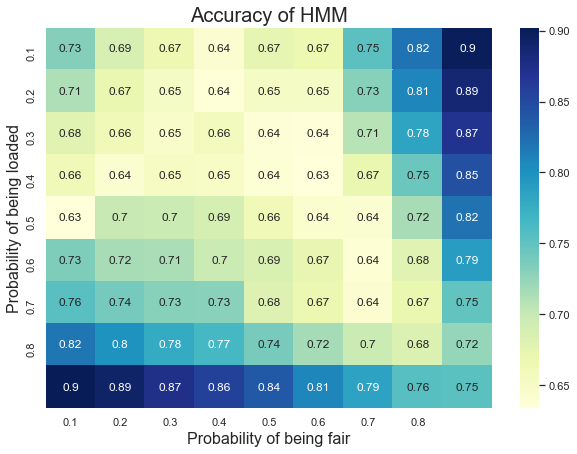

In [26]:
ax = plt.axes()
sns.set(rc={'figure.figsize':(10,7)})

sns.heatmap(ACC_mean, annot=True, cmap="YlGnBu", xticklabels=np.round(np.arange(.1, .9, .1),1), yticklabels=np.round(np.arange(.1, .9, .1),1)) 

ax.set_xlabel('Probability of being fair', fontsize=16)
ax.set_ylabel('Probability of being loaded', fontsize=16)
ax.set_title('Accuracy of HMM', fontsize=20)


HMMs can also be used to learn the model paramters given the data. 

Below we assume that we do not know the transition matrix, given by $\begin{bmatrix} 0.8&0.2 \\ 0.7&0.3 \end{bmatrix}$ and we try to learn it from the data. Results show that the HMM can approximate the true transition matrix quite well. The HMM performs equally well if only the emission probablities are unknown. However, the performace is poor if both are not given. In this case, one must run the EM algorithm over various  initializations to get reasonable results.

In [32]:
# Learning the transition matrix

# True parameters
p_fair = 0.8
p_unfair = 0.3

Data, States = generate_rolls(10000, p_fair, p_unfair)
Data = np.array([Data-1]).T

model = hmm.MultinomialHMM(n_components=2, init_params='t', params='t' , algorithm='viterbi', n_iter = 500)

model.startprob_ = np.array([1, 0])
#model.transmat_ = np.array([[p_fair, 1-p_fair],[1-p_unfair, p_unfair]])
model.emissionprob_ = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6],[0.1,0.1,0.1,0.1,0.1, 0.5]])

model.fit(Data)
model.decode(Data)

# Accurancy from decoding
result = model.decode(Data)[1]
print("Accuracy for the HMM without knowing the transition matrix:", 1 - np.sum(np.abs(result - States))/len(States))

Accuracy for the HMM without knowing the transition matrix: 0.7795


In [33]:
# The transition matrix learnt from data 
print('Transition matrix learnt from the data:',model.transmat_)


Transition matrix learnt from the data: [[0.81949414 0.18050586]
 [0.65588669 0.34411331]]


In [34]:
# Learning the emission probabilities

p_fair = 0.8
p_unfair = 0.3

Data, States = generate_rolls(10000, p_fair, p_unfair)
Data = np.array([Data-1]).T


model = hmm.MultinomialHMM(n_components=2, init_params='e', params='e', algorithm='viterbi', n_iter = 500)

model.startprob_ = np.array([1, 0])
model.transmat_ = np.array([[p_fair, 1-p_fair],[1-p_unfair, p_unfair]])
#model.emissionprob_ = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6],[0.1,0.1,0.1,0.1,0.1, 0.5]])

model.fit(Data)
model.decode(Data)

# Accurancy from decoding
result = model.decode(Data)[1]
(1 - np.sum(np.abs(result - States))/len(States))

0.7495

In [38]:
# Emission matrix learnt from EM algorithm
print('Emission probability from fair dice',model.emissionprob_[0,:])
print('Emission probability from loaded dice',model.emissionprob_[1,:])

Emission probability from fair dice [0.1716704  0.19050977 0.19318434 0.09391588 0.1393599  0.21135972]
Emission probability from loaded dice [0.05431236 0.03831234 0.02669632 0.34548283 0.21471684 0.32047931]


## Using HMM to identify Market regimes and predict direction of daily returns 

Markets are known to go through different phases, depending on various external factors. These phases are characterised by statistical properties that persist over an extended period of time. The performance of trading strategies can vary across different regimes and knowing which regime the market is in can aid in trading decisions. 

Our goal now is to predict the direction of the daily returns for the SP500. This is a difficult task because the returns have a near even split between up and down moves. Our strategy will be to learn the current market regime and then make a prediction based on that. 

We start by looking at the VIX and SP500 from 1995 to 2021. We compute the daily returns and their standard deviation over a 20 day period. 


In [46]:
VIX = pd.read_csv('VIX.csv')
SPX = pd.read_csv('SPX_CRSP.csv')
VIX = VIX.fillna(VIX.mean())
VIX = VIX.drop(2177)
VIX = VIX.set_index(np.arange(0 ,6525))
SPX = SPX[:-22]
# VIX remove 2177

### Correlation Matrix

In [47]:
Data = pd.concat([SPX['spindx'], SPX['sprtrn'], VIX['vix']], axis=1)

N = 20 # 20 has highest corr with VIX

Data['avgrtrn'] = Data['sprtrn'].rolling(N).mean()
Data['stdrtrn'] = Data['sprtrn'].rolling(N).std()
Data = Data.dropna()

Data.corr()

,spindx,sprtrn,vix,avgrtrn,stdrtrn
spindx,1.000000,0.013696,-0.202718,0.051964,-0.118937
sprtrn,0.013696,1.000000,-0.125630,0.219418,0.007535
vix,-0.202718,-0.125630,1.000000,-0.406308,0.880054
avgrtrn,0.051964,0.219418,-0.406308,1.000000,-0.335701
stdrtrn,-0.118937,0.007535,0.880054,-0.335701,1.000000


### Selecting number of Hidden States


The first must identify the appropritate number of hidden states. The hidden states should make some economic sense and we need to avoid using too any hidden states due to overfitting. We plot the log-likelihood for states and ranging from 2 to 8. Looking at the plot below, 3 appears to be the optimal choice.

In [49]:
Log_lik = []

for n_comp in range(2,8):
    model = hmm.GaussianHMM(n_components = n_comp, covariance_type='full',n_iter = 100)
    model.fit(Data[[ 'sprtrn']])
    
    Log_prob = model.score(Data[['sprtrn']])
    M = Data.shape[0]
    n_feat = model.n_features
    # For full use n_feat**2 and for diag use n_feat
    K = (n_feat + n_feat**2)*n_comp + (n_comp-1) + n_comp*(n_comp - 1)
    
    Log_lik.append(Log_prob)
#     AIC.append(-2*Log_prob + 2*K)
#     BIC.append(-2*Log_prob + K * np.log(M))
#     HQC.append(-2*Log_prob + K * np.log(np.log(M)))
#     print('state:', n_comp, 'done')
    


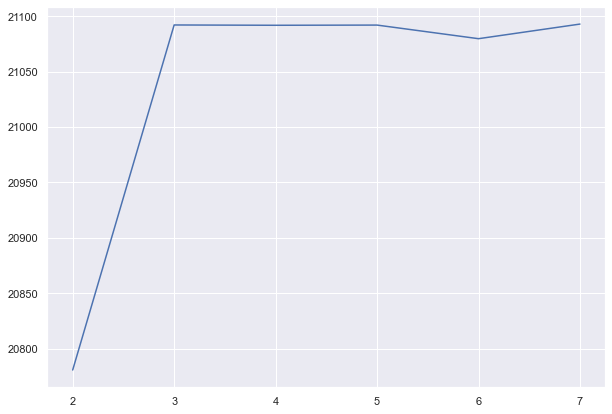

In [50]:
plt.plot(np.arange(2,8), Log_lik)

### Decoding the SP500 returns

We now decode the SP500 daily returns using an HMM with 3 hidden states. We assume that the distribution of the returns given a state is Gaussian.

In [52]:
model = hmm.GaussianHMM(n_components = 3, covariance_type='full',n_iter = 100)
model.fit(Data[['sprtrn']])
States = model.decode(Data[['sprtrn']])
print("log likelihood:", States[0])

log likelihood: 20913.130038067742


The mean return and volatility of each of the three decoded states is given below. We can clearly see that the HMM divides the data into three groups: high positive returns with low vol (state 1), negtive returns with high vol (state 0) and low positive returns with medium vol (state 2).

In [55]:
# Descriptive statistics for each state under HMM classification 
Data['state'] = (States[1]).tolist()

Data[['sprtrn', 'vix', 'stdrtrn', 'state']].groupby('state').describe().loc[:,(slice(None),['count','mean'])]
Data['next_rtrn'] = Data['sprtrn'].shift(-1)
temp_Data = Data.dropna()
temp_Data[['sprtrn', 'vix', 'stdrtrn', 'state', 'next_rtrn']].groupby('state').describe().loc[:,(slice(None),['count','mean'])]


sprtrn               vix            stdrtrn           next_rtrn  \
        count      mean   count       mean   count      mean     count   
state                                                                    
0       320.0 -0.002683   320.0  43.903094   320.0  0.029396     320.0   
1      3299.0  0.000986  3299.0  14.515468  3299.0  0.006443    3299.0   
2      2886.0  0.000045  2886.0  23.668940  2886.0  0.012416    2886.0   

                 
           mean  
state            
0     -0.001554  
1      0.000846  
2      0.000079

The distribution of each of the three states can be seen below.

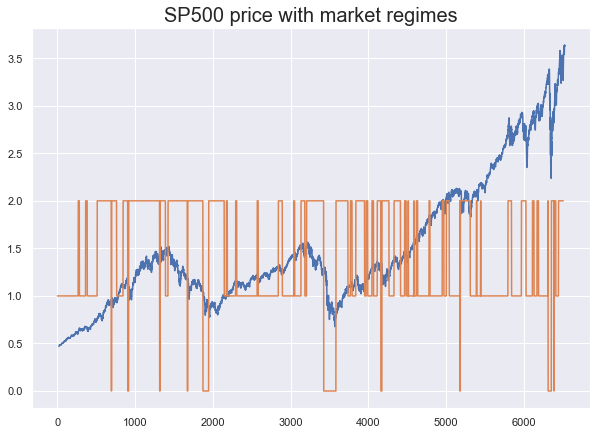

In [61]:
plt.plot(Data['spindx']/1000)
plt.plot((States[1]))
plt.title('SP500 price with market regimes', fontsize=20)
plt.show()

<AxesSubplot:xlabel='stdrtrn', ylabel='sprtrn'>

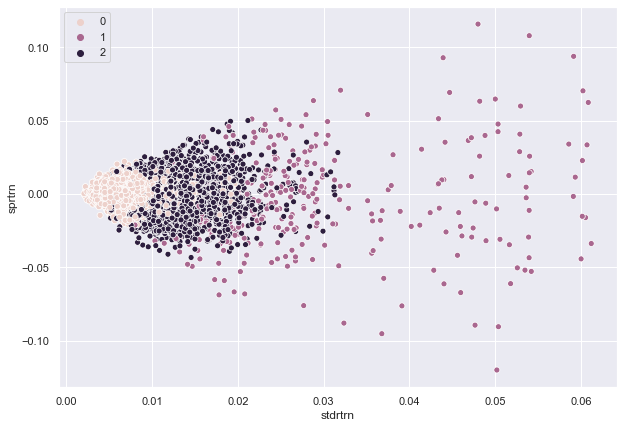

In [25]:
sns.scatterplot(y=Data['sprtrn'],x=Data['stdrtrn'], hue=Data['state'].tolist())

### HMMs do not naively classify market regimes based on some threshold

It is important to note that the HMM does not naively identify the market regimes simply based on returns. It is taking into account the volatilty, which as we saw earlier has no correlation with returns, even though it was only trained using daily returns. In contrast, we show below what a naive clustering of the returns would look like using k-means.

This is useful beacuse it tells us that the HMM can help us in trading decisions and improve our predictions.

sprtrn               vix            stdrtrn          
         count      mean   count       mean   count      mean
k_mean                                                       
0        968.0 -0.018269   968.0  26.715702   968.0  0.013914
1       4468.0  0.000454  4468.0  17.783465  4468.0  0.008579
2       1070.0  0.016985  1070.0  23.315262  1070.0  0.013745

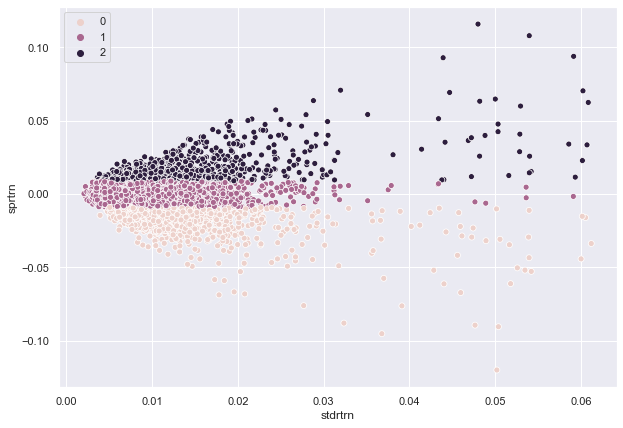

In [63]:
# Classifying Market states using K-Means

from sklearn.cluster import MiniBatchKMeans 

minibatch_kmeans = MiniBatchKMeans(n_clusters=3)   
y_pred = minibatch_kmeans.fit_predict(Data[[ 'sprtrn']])

Data['k_mean'] = y_pred.tolist()
sns.set(rc={'figure.figsize':(10,7)})
sns.scatterplot(y=Data['sprtrn'],x=Data['stdrtrn'], hue=Data['k_mean'].tolist())
Data[['sprtrn', 'vix', 'stdrtrn', 'k_mean']].groupby('k_mean').describe().loc[:,(slice(None),['count','mean'])]



In [36]:
# Descriptive statistics for each state under K means classification 

model = hmm.GaussianHMM(n_components = 3, covariance_type='full',n_iter = 500)
model.fit(Data[['sprtrn']])
States = model.decode(Data[['sprtrn']])
print("log likelihood:", States[0])

Data['state'] = (States[1]).tolist()
Data['next_rtrn'] = Data['sprtrn'].shift(-1)
temp_Data = Data.dropna()
temp_Data[['sprtrn', 'vix', 'stdrtrn', 'state', 'next_rtrn']].groupby('state').describe().loc[:,(slice(None),['count','mean'])]


log likelihood: 20913.1913515282


sprtrn               vix            stdrtrn           next_rtrn  \
        count      mean   count       mean   count      mean     count   
state                                                                    
0      3299.0  0.000986  3299.0  14.515468  3299.0  0.006443    3299.0   
1       320.0 -0.002683   320.0  43.903094   320.0  0.029396     320.0   
2      2886.0  0.000045  2886.0  23.668940  2886.0  0.012416    2886.0   

                 
           mean  
state            
0      0.000846  
1     -0.001554  
2      0.000079

### Predicting daily return direction

We now demonstrate how HMMs can be used to improve the prediction of daily return direction. As noted earlier, the return directions are highly random with an almost even split and as such our imporovemnt is only marginal due to the difficult nature of the problem. We use 75% of the daily returns to train our model and then test and compare it to a benchmark over 20 equally spaced time periods in the future. 

We compare two strategies:

The first one involves predicting an *up* direction if the market is in the 'high return low vol' state. For other states we assign a direction randomly. We compare this strategy to a benchmark that chooses the direction randomly.

The second strategy involves predicting an *up* direction if the market is in the 'high return low vol' state and *down* for every other state. We compare this to a benchmark that chooses an up direction each day. This is a better benchmark because we have a higher proportion of up moves compared to down moves over the entire time period. 



In [78]:
import random

labels = np.array(np.sign(temp_Data['next_rtrn']))  # Next day returns direction.
size = np.shape(labels)[0]
up_label = [x for x in labels if x==1]
down_label = [x for x in labels if x == -1]

up = len(up_label)/len(labels)
down = len(down_label)/len(labels)

def rand_gen(p):
    """
    Generates 1 with prob p and -1 with prob (1-p)
    """
    x = random.uniform(0,1)
    if x <= p:
        return 1
    else:
        return -1

hmm_labels = np.array(temp_Data['state'])
rand_labels = []
hmm_rand_labels = []

In [68]:
up = []
down = []
rand = []
hmm_result = []
hmm2_result = []


for i in range(0,21):
    
    j = i*75
    end_id = 5005
    trunc_Data = temp_Data[:end_id+j]
    
    labels = np.array(np.sign(trunc_Data['next_rtrn']))
    
    size = np.shape(labels)[0]
    up_label = [x for x in labels if x==1]
    down_label = [x for x in labels if x == -1]
    
    up.append(len(up_label)/len(labels))
    down.append(len(down_label)/len(labels))
    
    
    model = hmm.GaussianHMM(n_components = 3, covariance_type='full',n_iter = 100)
    model.fit(trunc_Data[['sprtrn']])
    States = model.decode(trunc_Data[['sprtrn']])
    
    trunc_Data['state'] = (States[1]).tolist()
    df_mean = trunc_Data[['sprtrn','state']].groupby('state').mean()
    max_state = df_mean['sprtrn'].argmax()
    min_state = df_mean['sprtrn'].argmin()

    
    hmm_labels = np.array(States[1])
    hmm_direction = []
    for i in range(size):
        if hmm_labels[i] == max_state :
            hmm_direction.append(1)
        else:
            hmm_direction.append(-1)
            #hmm.append(rand_gen(up))

    hmm_result.append(len([x for x in (labels-hmm_direction) if x == 0])/size)
    
    hmm2_direction = []
    rand_direction = []
    for i in range(size):
        
        rr = rand_gen(up[-1])
        rand_direction.append(rr)
        
        if hmm_labels[i] == max_state :
            hmm2_direction.append(1)
        else:
            hmm2_direction.append(rr)

    hmm2_result.append(len([x for x in (labels-hmm2_direction) if x == 0])/size)
    rand.append(len([x for x in (labels-rand_direction) if x == 0])/size)




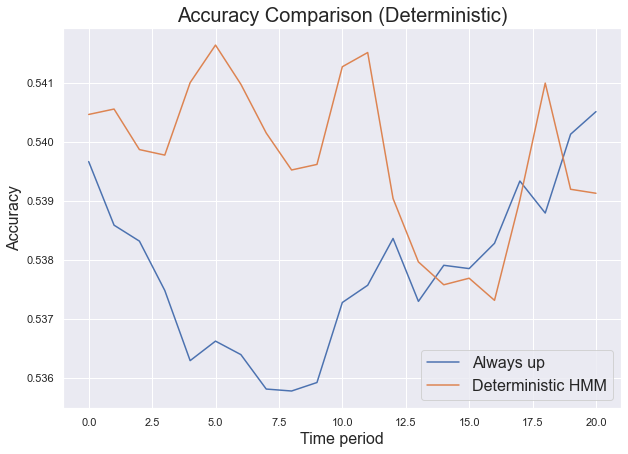

In [77]:
plt.plot(up, label = 'Always up')
plt.plot(hmm_result, label = 'Deterministic HMM')
plt.legend(fontsize=16)
plt.xlabel('Time period',fontsize=16 )
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Comparison (Deterministic)', fontsize=20)
plt.show()

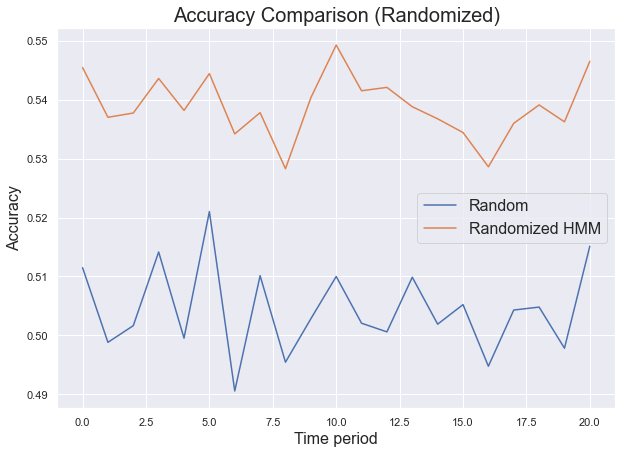

In [76]:
plt.plot(rand, label = 'Random')
plt.plot(hmm2_result, label = 'Randomized HMM')
plt.legend(fontsize=16)
plt.xlabel('Time period',fontsize=16 )
plt.ylabel('Accuracy', fontsize=16)
plt.title('Accuracy Comparison (Randomized)', fontsize=20)
plt.show()

### Conclusions and Future work

We can see from our two tests that using HMMs can improve on the accuracy of return direction prediction. This shows that knowing the market regime can provide important statistical properties about the market that a trader can use when deploying strategies.

Future work will involve testing various trading strategies under different market regimes to identify which strategy works well under which circumstances.

